In [1]:
using LinearAlgebra
using DataFrames,CSV
using Plots
using Statistics
using BetaML: partition
using Flux
using Distributions
using ProgressMeter
using BSON


In [2]:
function fc(Rij::T, Rc::T) :: T where {T}
    #se sto oltre al cutoff restituisco 0
    if Rij>=Rc
        return 0
    else 
        arg=1-1/(1-(Rij/Rc)*(Rij/Rc))

        return exp(arg)

    end
end

fc (generic function with 1 method)

In [3]:
# Definizione del dizionario
element_charge = Dict(
    "H" => 1,
    "He" => 2,
    "Li" => 3,
    "Be" => 4,
    "B" => 5,
    "C" => 6,
    "N" => 7,
    "O" => 8,
    "F" => 9,
    "Ne" => 10,
    "Na" => 11,
    "Mg" => 12,
    "Al" => 13,
    "Si" => 14,
    "P" => 15,
    "S" => 16,
    "Cl" => 17,
    "Ar" => 18,
    "K" => 19,
    "Ca" => 20,
    "Sc" => 21,
    "Ti" => 22,
    "V" => 23,
    "Cr" => 24,
    "Mn" => 25,
    "Fe" => 26,
    "Co" => 27,
    "Ni" => 28,
    "Cu" => 29,
    "Zn" => 30,
    "Ga" => 31,
    "Ge" => 32,
    "As" => 33,
    "Se" => 34,
    "Br" => 35,
    "Kr" => 36,
    "Rb" => 37,
    "Sr" => 38,
    "Y" => 39,
    "Zr" => 40,
    "Nb" => 41,
    "Mo" => 42,
    "Tc" => 43,
    "Ru" => 44,
    "Rh" => 45,
    "Pd" => 46,
    "Ag" => 47,
    "Cd" => 48,
    "In" => 49,
    "Sn" => 50,
    "Sb" => 51,
    "Te" => 52,
    "I" => 53,
    "Xe" => 54,
    "Cs" => 55,
    "Ba" => 56,
    "La" => 57,
    "Ce" => 58,
    "Pr" => 59,
    "Nd" => 60,
    "Pm" => 61,
    "Sm" => 62,
    "Eu" => 63,
    "Gd" => 64,
    "Tb" => 65,
    "Dy" => 66,
    "Ho" => 67,
    "Er" => 68,
    "Tm" => 69,
    "Yb" => 70,
    "Lu" => 71,
    "Hf" => 72,
    "Ta" => 73,
    "W" => 74,
    "Re" => 75,
    "Os" => 76,
    "Ir" => 77,
    "Pt" => 78,
    "Au" => 79,
    "Hg" => 80,
    "Tl" => 81,
    "Pb" => 82,
    "Bi" => 83,
    "Po" => 84,
    "At" => 85,
    "Rn" => 86,
    "Fr" => 87,
    "Ra" => 88,
    "Ac" => 89,
    "Th" => 90,
    "Pa" => 91,
    "U" => 92,
    "Np" => 93,
    "Pu" => 94,
    "Am" => 95,
    "Cm" => 96,
    "Bk" => 97,
    "Cf" => 98,
    "Es" => 99,
    "Fm" => 100,
    "Md" => 101,
    "No" => 102,
    "Lr" => 103,
    "Rf" => 104,
    "Db" => 105,
    "Sg" => 106,
    "Bh" => 107,
    "Hs" => 108,
    "Mt" => 109,
    "Ds" => 110,
    "Rg" => 111,
    "Cn" => 112,
    "Nh" => 113,
    "Fl" => 114,
    "Mc" => 115,
    "Lv" => 116,
    "Ts" => 117,
    "Og" => 118,
)
println("\n")

In [4]:
# Funzione per estrarre i primi 3 numeri non nulli da una stringa di lattice
function extract_lattice_vector(lattice_str)
    # Estrae i numeri dalla stringa, ignorando tutto tranne i numeri e i punti
    filtered = filter(x -> !isempty(x) && parse(Float64, x) != 0.0, 
                      split(replace(lattice_str, r"[^\d.\s]" => "")))

    # Controlla se ci sono almeno 3 valori non nulli
    if length(filtered) < 3
        println("Warning: Less than 3 non-zero lattice values found.")
        return Float32[]  # Restituisce un array vuoto di tipo Float32
    end

    # Restituisce i primi 3 numeri non nulli convertiti in Float32
    return parse.(Float32, filtered[1:3])  # Convertito in Float32
end


extract_lattice_vector (generic function with 1 method)

In [5]:
function extract_energy(line)
    # Trova la sottostringa che inizia con "energy="
    if occursin("energy=", line)
        # Dividi la riga sulla sottostringa "energy="
        parts = split(line, "energy=")
        # Prendi la parte dopo "energy="
        energy_str = parts[2]
        # Trova il primo carattere non numerico (che segna la fine del numero)
        end_idx = findfirst(c -> !isdigit(c) && c != '.' && c != '-', energy_str) - 1
        # Estrai il numero come sottostringa e convertilo in Float32
        energy_value = parse(Float32, energy_str[1:end_idx])  # Convertito in Float32
        return energy_value
    else
        error("La stringa non contiene 'energy='")
    end
end


extract_energy (generic function with 1 method)

In [6]:
# Funzione per processare un dataset
function process_dataset(file_path)
    dataset = []  # Contiene tutti i dataset processati
    current_dataset = []  # Dataset attuale per la struttura corrente
    all_lattice = []  # Vettori di lattice per tutte le strutture
    all_energies = []  # Energia per tutte le strutture

    open(file_path, "r") do file
        while !eof(file)
            line = readline(file) |> strip  # Rimuovi spazi bianchi dalla linea

            if line == "40"
                # Se troviamo '40', salva il dataset corrente e inizializza uno nuovo
                if !isempty(current_dataset)
                    push!(dataset, current_dataset)
                end
                current_dataset = []
            elseif startswith(line, "pbc=")
                # Estrai i vettori di lattice dalla linea corrispondente
                lattice_line = split(line, "Lattice=")[2]
                lattice_data = extract_lattice_vector(lattice_line)
                energy = extract_energy(lattice_line)
                push!(all_lattice, Float32.(lattice_data))  # Assicurati che il lattice sia di tipo Float32
                push!(all_energies, Float32(energy))  # Converti l'energia in Float32
            else
                # Suddividi la linea in parti e analizza coordinate e forze
                parts = split(line)
                if length(parts) < 7
                    continue  # Salta se i dati non sono completi
                end
                element = parts[1]

                # Estrai e converti le coordinate e le forze in Float32
                coordinates = Float32.(parse.(Float32, parts[2:4]))  
                forces = Float32.(parse.(Float32, parts[5:7]))  
                charge = Float32(get(element_charge, element, 0.0))  # Ottieni la carica dell'elemento e converti in Float32
                
                # Aggiungi al dataset corrente: carica, coordinate e forze
                push!(current_dataset, [charge, coordinates..., forces...])
            end
        end
        
        # Aggiungi l'ultimo dataset se non è vuoto
        if !isempty(current_dataset)
            push!(dataset, current_dataset)
        end
    end

    return all_lattice, dataset, all_energies
end


process_dataset (generic function with 1 method)

In [7]:
# Funzione per calcolare la distanza con condizioni periodiche
function distance_with_pbc(pos1, pos2, lattice_vectors)
    delta = pos2 .- pos1
    # Applichiamo le condizioni periodiche al bordo (PBC)
    delta_pbc = delta .- lattice_vectors .* round.(delta ./ lattice_vectors)
    return norm(delta_pbc)
end

distance_with_pbc (generic function with 1 method)

In [8]:
# Funzione per creare l'array degli input per la rete neurale
function create_nn_input(dataset, all_lattice)
    num_datasets = length(dataset)
    num_atoms = 40  # ci sono sempre 40 atomi per dataset

    # Array degli input: (num_datasets, num_atoms, 40) di tipo Float32
    nn_input = Array{Float32, 3}(undef, num_datasets, num_atoms, 40)

    for i in 1:num_datasets
        current_dataset = dataset[i]
        lattice_vectors = all_lattice[i]

        for j in 1:num_atoms
            atom_j = current_dataset[j]
            charge_j = atom_j[1]  # Assicurati che sia un valore scalare
            pos_j = atom_j[2:4]

            # Inseriamo la carica dell'atomo nel primo slot
            nn_input[i, j, 1] = Float32(charge_j)

            # Convertiamo le posizioni in Float32
            pos_j_float = Float32.(pos_j)

            # Calcoliamo la distanza dagli altri atomi
            slot_index = 2  # Partiamo dal secondo slot
            for k in 1:num_atoms
                if j == k
                    continue  # Ignoriamo la distanza con se stesso
                end
                atom_k = current_dataset[k]
                pos_k = atom_k[2:4]

                # Convertiamo le posizioni in Float32
                pos_k_float = Float32.(pos_k)

                # Calcoliamo la distanza con PBC
                distance = distance_with_pbc(pos_j_float, pos_k_float, lattice_vectors)

                # Assicurati che la distanza sia di tipo Float32
                nn_input[i, j, slot_index] = Float32(distance)
                slot_index += 1  # Avanziamo nel prossimo slot
            end
        end
    end

    return nn_input
end


create_nn_input (generic function with 1 method)

In [9]:
struct MyLayer
    W_eta::AbstractArray  # Pesi per il collegamento "eta"
    W_Fs::AbstractArray   # Pesi per il collegamento "Fs"
    cutoff::Float32       # Raggio di cutoff
    charge::Float32       # carica dell'atomo
end

# Funzione per creare il MyLayer con inizializzazione dei pesi
function MyLayer(input_dim::Int, hidden_dim::Int, cutoff::Float32, charge::Float32)
    W_eta = Float32.(rand(Uniform(0.25, 2.5), hidden_dim, input_dim))  # Inizializza i pesi come Float32
    W_Fs = Float32.(rand(Uniform(0.0, 2.5), hidden_dim, input_dim))    # Inizializza i pesi come Float32
    MyLayer(W_eta, W_Fs, cutoff, charge)
end

# Funzione di forward pass per il layer
function (layer::MyLayer)(x)
    N_Atomi_Vicini = size(x)[1]
    sum = zeros(size(layer.W_eta)[1])

    for j in 1:N_Atomi_Vicini
        sum = sum .+ layer.charge.*fc(x[j], layer.cutoff) .* exp.(-(x[j] .- layer.W_Fs) .* (x[j] .- layer.W_Fs) .* layer.W_eta)
    end
    return Float32.(sum)
end

# Definizione per mostrare il layer
function Base.show(io::IO, layer::MyLayer)
    println(io, "CustomLayer with two links per input neuron (eta and Fs)")
    println(io, "Weights eta: ", layer.W_eta)
    println(io, "Weights Fs: ", layer.W_Fs)
end

Flux.@layer MyLayer

In [10]:
# Specifica il percorso del file
file_path = "train.xyz"

R_cutoff=6.0f0#( In armstrong )

# Ottieni i vettori di lattice e i dataset
lattice_vectors, datasets, energies = process_dataset(file_path)

println(" ")
#println("Lattice vectors: ", lattice_vectors[1]) #qui ci sono le 3 coordinate dell'array di lattice ( uguali per tutti gli elementi del dataset )
#println("Datasets: ", datasets[1])

#l'array è fatto come segue:
#ci sono 785 dataset, in ogni dataset ci sono 40 elementi,
#la riga associata a questi elementi è lunga 7
#gli elementi sono i seguenti: 
#la carica nucleare dell'atomo
#le coordinate x,y,z
#la forza della quale risente l'atomo in componenti x,y,z


# Creazione del dataset per la rete neurale
nn_input_dataset = create_nn_input(datasets, lattice_vectors)

# Verifica delle dimensioni dell'array finale
println("Dimensioni dell'array nn_input_dataset: ", size(nn_input_dataset))

 
Dimensioni dell'array nn_input_dataset: (785, 40, 40)


In [11]:


# Calcola la media e la deviazione standard di energies
mean_energy = mean(energies)
std_energy = std(energies)

# Crea l'istogramma
histogram(energies, bins=30, color="skyblue", alpha=0.7, label="" , normalize=true)

# Imposta i titoli degli assi e il titolo dell'istogramma
xlabel!("Energia [eV]")
ylabel!("Frequenza")
title!("Distribuzione delle Energie")

# Aggiungi media e deviazione standard in alto a destra
x_position = -28877.5
y_position = 1.2 # posizione in base all'altezza massima dell'istogramma

annotate!(x_position, y_position, text("Media: $(round(mean_energy, digits=2)) eV\nDeviazione Std: $(round(std_energy, digits=2)) eV", :right, 12))

# Salva o mostra il grafico
 savefig("istogramma_energie.png")  # Salva il grafico come file


"C:\\Users\\biaxb\\OneDrive\\A3 S2\\Tesi\\Materiale definitivo\\Perovskite\\istogramma_energie.png"

In [12]:
# Partitioning
((x_train, tempX), (y_train, tempY)) = partition([nn_input_dataset, energies], [0.7, 0.3])
((x_vali, x_test), (y_vali, y_test)) = partition([tempX, tempY], [0.5, 0.5])

histogram(y_train, bins=30, alpha=0.5, label="bro", legend=:topright, normalize=true)
plot!()
# Assicurati che y_train, y_vali e y_test siano Float32
y_train = Float32.(y_train)  # Converte in Float32
y_vali = Float32.(y_vali)    # Converte in Float32
y_test = Float32.(y_test)    # Converte in Float32

#x_mean = mean(x_train[:, :, 2:40])
#x_std = std(x_train[:, :, 2:40])


#x_train[:, :, 2:40] .= (x_train[:, :, 2:40] .- x_mean) ./ x_std
#x_test[#:, :, 2:40] .= (x_test[:, :, 2:40] .- x_mean) ./ x_std
#x_vali[:, :, 2:40] .= (x_vali[:, :, 2:40] .- x_mean) ./ x_std

# applico una normalizzazione z-score
y_mean_1 = mean(y_train)
y_std_1 = std(y_train)


# Prima normalizzazione
y_train .= (y_train .- y_mean_1) ./ y_std_1

# Nuovo calcolo della media e deviazione standard
y_mean_2 = mean(y_train)
y_std_2 = std(y_train)


# Seconda normalizzazione
y_train .= (y_train .- y_mean_2 ) ./ y_std_2

# Media reale e deviazione standard reale
y_mean = y_mean_2 * y_std_1 + y_mean_1  # Inversione della prima normalizzazione
y_std = y_std_2 * y_std_1                 # Inversione della deviazione standard

y_vali .= (y_vali .- y_mean) ./ y_std
y_test .= (y_test .- y_mean) ./ y_std

# Stampa delle dimensioni
println("Dimensioni di x_train: ", size(x_train))
println("Dimensioni di x_vali: ", size(x_vali))
println("Dimensioni di x_test: ", size(x_test))


Dimensioni di x_train: (550, 40, 40)
Dimensioni di x_vali: (118, 40, 40)
Dimensioni di x_test: (117, 40, 40)


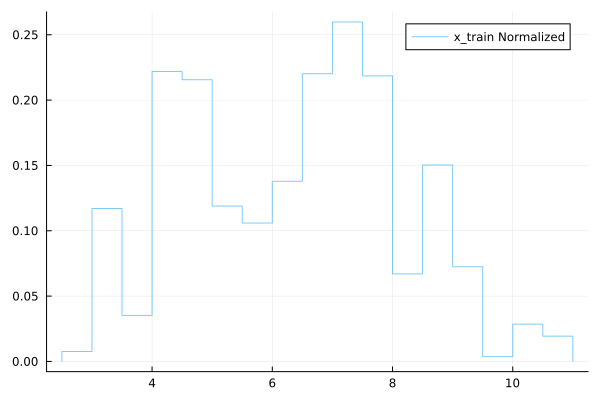

In [13]:


# Supponendo che x_train e y_train siano già normalizzati e disponibili

# Estrai gli elementi desiderati da x_train
x_train_subset = nn_input_dataset[:, :, 2:40]

# Funzione per plottare la distribuzione
function plot_distribution(data, label)
    # Flatten the data for histogram
    flattened_data = vec(data)  # Convert 3D array to 1D
    histogram(flattened_data, bins=30, alpha=0.5, label=label, legend=:topright, normalize=true)
    plot!()
end

# Plottare la distribuzione degli elementi di x_train
plot_distribution(x_train_subset, "x_train Normalized")



# Plottare la distribuzione di y_train
#plot_distribution(y_train, "y_train Normalized")




In [14]:
G1_Number=5

charge_Cs=5.30f0
charge_Pb=8.50f0
charge_I=5.50f0

Cs_model = Chain(
    MyLayer(1, G1_Number, R_cutoff, charge_Cs),
    Dense(G1_Number, 15, tanh),
    Dense(15, 10, tanh),
    Dense(10, 5, tanh),
    Dense(5, 1)
)

Pb_model = Chain(
    MyLayer(1, G1_Number, R_cutoff, charge_Pb),
    Dense(G1_Number, 15, tanh),
    Dense(15, 10, tanh),
    Dense(10, 5, tanh),
    Dense(5, 1)
)

I_model = Chain(
    MyLayer(1, G1_Number, R_cutoff, charge_I),
    Dense(G1_Number, 15, tanh),
    Dense(15, 10, tanh),
    Dense(10, 5, tanh),
    Dense(5, 1)
)



Chain(
  CustomLayer with two links per input neuron (eta and Fs)
Weights eta: Float32[0.8251386; 0.4991399; … ; 1.4467964; 2.3076267;;]
Weights Fs: Float32[0.67667913; 0.9571448; … ; 1.156021; 1.1815478;;]
,  # 10 parameters
  Dense(5 => 15, tanh),                 # 90 parameters
  Dense(15 => 10, tanh),                # 160 parameters
  Dense(10 => 5, tanh),                 # 55 parameters
  Dense(5 => 1),                        # 6 parameters
)                   # Total: 10 arrays, 321 parameters, 1.902 KiB.

In [15]:
function loss_function(data, energies)
    total_loss = 0.0
    n_structures = size(data)[1]
    
    for k in 1:n_structures # ciclo sui dataset
        temp = 0.0
        n_atoms = size(data)[2] # numero di atomi
        
        for i in 1:n_atoms # ciclo sugli atomi del dataset
            charge = data[k, i, 1]
            features = data[k, i, 2:40]
            
            if charge == 55.0 # per Iodio
                temp += I_model(features)[1]
            elseif charge == 85.0 # per Piombo
                temp += Pb_model(features)[1]
            elseif charge == 53.0 # per Cesio
                temp += Cs_model(features)[1]
            end
        end
        
        total_loss += abs2(temp - energies[k])
    end
    
    return total_loss / n_structures # Media della perdita
end





loss_function (generic function with 1 method)

In [ ]:
# Imposta i parametri dell'ottimizzatore
initial_lr = 0.01f0
min_lr = 1e-5 # Valore minimo del learning rate
decay_factor = 0.5  # Fattore di riduzione del learning rate
patience = 25  # Numero di epoche prima di ridurre il learning rate
no_improve_count = 0  # Contatore per il numero di epoche senza miglioramento

# Inizializza l'ottimizzatore
opt = Flux.Adam(initial_lr)

# Numero di epoche di addestramento
epochs = 3000
best_epoch = 0
best_loss = Inf
# Per salvare il miglior modello
best_I_model = deepcopy(I_model)
best_Cs_model = deepcopy(Cs_model)
best_Pb_model = deepcopy(Pb_model)

# Array per salvare le loss
LossTrain = zeros(Float32, epochs)
LossVali = zeros(Float32, epochs)

# Inizializza la barra di progresso
@showprogress for epoch in 1:epochs
    # Training in batch
    batch_size = 32  # Dimensione del batch
    for i in 1:batch_size:size(x_train, 1)
        # Limita l'indice per non superare le dimensioni dell'array
        end_index = min(i + batch_size - 1, size(x_train, 1))
        
        # Crea il mini-batch
        x_batch = x_train[i:end_index, :, :]
        y_batch = y_train[i:end_index]

        # Aggiorna il modello
        Flux.train!(loss_function, Flux.params(I_model, Cs_model, Pb_model), [(x_batch, y_batch)], opt)
    end

    # Calcolo delle perdite
    LossTrain[epoch] = loss_function( x_train, y_train)
    LossVali[epoch] = loss_function( x_vali, y_vali)

   # Salvo il best model se è migliorato almeno del 5%
    if LossVali[epoch] < best_loss * 0.95
        best_epoch = epoch
        best_loss = LossVali[epoch]
        best_I_model = deepcopy(I_model)
        best_Cs_model = deepcopy(Cs_model)
        best_Pb_model = deepcopy(Pb_model)
    end
    
    # Stampa la perdita ogni 500 epoche
    if epoch % 500 == 0
        println("Epoch $epoch: Training Loss = $(LossTrain[epoch]), Validation Loss = $(LossVali[epoch])")
        println("Epoch $epoch: Best Loss = $(best_loss)")
    end
    # Riduci il learning rate se non ci sono stati miglioramenti per 'patience' epoche
    if no_improve_count >= patience
        new_lr = max(opt.lr * decay_factor, min_lr)  # Riduci il learning rate ma non scendere sotto min_lr
        opt = Flux.Adam(new_lr)  # Reimposta l'ottimizzatore con il nuovo learning rate
        no_improve_count = 0  # Reset della conta
        println("Reducing learning rate to $(new_lr) at epoch $epoch")
    end
end

# Assegna i migliori modelli
I_model = best_I_model
Pb_model = best_Pb_model
Cs_model = best_Cs_model

# Salva il miglior modello in locale come BSON
BSON.@save "best_I_model.bson" I_model
BSON.@save "best_Cs_model.bson" Cs_model
BSON.@save "best_Pb_model.bson" Pb_model

println("Final Training Loss: $(loss_function(x_train, y_train))")
println("Final Validation Loss: $(loss_function(x_vali, y_vali))")
println("Final Training RMSE: $(y_std * sqrt((loss_function(x_train, y_train)))) eV")
println("Final Validation RMSE: $(y_std * sqrt((loss_function(x_vali, y_vali)))) eV")
println("Il modello migliore è stato trovato all'epoca: $best_epoch")


Progress:   0%|█                                        |  ETA: 21:01:0117

In [ ]:
plot(1:epochs,LossTrain,label="Train", yscale=:log10)
plot!(1:epochs,LossVali,label="Validation", yscale=:log10,linestyle=:dot)
plot!([best_epoch,best_epoch],[minimum([minimum(LossTrain), minimum(LossVali)]),1],label="Best Epoch",color="black",linestyle=:dash, linewidth=2)
ylabel!("Loss")
xlabel!("Epoca")
title!("Loss in funzione dell'epoca")
savefig("andamento_loss_Perovskite.png")

In [ ]:
Loss_normalizzata_Train=sqrt.(LossTrain)
Loss_normalizzata_Vali=sqrt.(LossVali)

Loss_eV_Vali=Loss_normalizzata_Vali.*y_std
Loss_eV_Train=Loss_normalizzata_Train.*y_std

plot(1:epochs,Loss_eV_Train,label="Train", yscale=:log10)
plot!(1:epochs,Loss_eV_Vali,label="Validation", yscale=:log10,linestyle=:dot)
plot!([best_epoch,best_epoch],[minimum([minimum(LossTrain), minimum(LossVali)]),1],label="Best Epoch",color="black",linestyle=:dash, linewidth=2)
ylabel!("radice quadrata della Loss [eV]")
xlabel!("Epoca")
title!("Radice quadrata della Loss in funzione dell'epoca")
savefig("andamento_loss_Perovskite_eV.png")

In [ ]:
# Rinormalizzazione di y_train
y_train_normalized = y_train.*y_std  .+ y_mean   # riscalo y_train

# Array per salvare l'energia totale predetta riconvertita
predicted_energy_total = zeros(size(y_train_normalized))

# Calcola l'energia totale predetta per ciascun sistema, riportando i dati alla scala originale
for k in 1:size(x_train)[1]
    total_energy = 0.0
    for i in 1:40
        
        charge = x_train[k, i, 1]
        features = x_train[k, i, 2:40]
            
        if charge == 55.0 # per Iodio
            total_energy += I_model(features)[1]
        elseif charge == 85.0 # per Piombo
            total_energy += Pb_model(features)[1]
        elseif charge == 53.0 # per Cesio
            total_energy += Cs_model(features)[1]
        end
    end
    # Riconversione dell'energia totale predetta in meV
    predicted_energy_total[k] = total_energy * y_std + y_mean  # Riconversione
end

# Calcolo del coefficiente di Pearson
pearson_coeff = cor(y_train_normalized, predicted_energy_total)[1]


# Limiti per la linea ideale basati sui dati originali
min_energy = minimum(y_train_normalized) * 1.00001
max_energy = maximum(y_train_normalized) * 1.00001

# Plot Predicted vs Real
plot([min_energy, max_energy], [min_energy, max_energy], color="black", label="Andamento ideale", legendfont=font(12))  # Modifica qui per aumentare la dimensione della legenda
scatter!(y_train_normalized, predicted_energy_total, label="Energia", alpha=0.5, color="red")

# Settaggi degli assi e del titolo
ylabel!("Valore predetto (eV)")  # Modificato qui
xlabel!("Valore reale (eV)")  # Modificato qui
title!("Train set: Valore predetto vs valore reale")
xlims!(min_energy, max_energy)
ylims!(min_energy, max_energy)

# Posizione dell'annotazione in termini percentuali
x_position = min_energy + 0.015 * (max_energy - min_energy)  # 97% lungo l'asse x
y_position = min_energy + 0.75 * (max_energy - min_energy)  # 55% lungo l'asse y

# Aggiungi il coefficiente di Pearson al plot
annotate!([(x_position, y_position, text("Coefficiente di Pearson: $(round(pearson_coeff, digits=3))", :left, 12))])

# Salva il plot
savefig("correlazione_train_Perovskite.png")


In [ ]:
# Rinormalizzazione di y_train
y_validation_normalized = y_vali.*y_std  .+ y_mean   # riscalo y_train

# Array per salvare l'energia totale predetta riconvertita
predicted_energy_total = zeros(size(y_validation_normalized))

# Calcola l'energia totale predetta per ciascun sistema, riportando i dati alla scala originale
for k in 1:size(x_vali)[1]
    total_energy = 0.0
    for i in 1:40
        
        charge = x_vali[k, i, 1]
        features = x_vali[k, i, 2:40]
            
        if charge == 55.0 # per Iodio
            total_energy += I_model(features)[1]
        elseif charge == 85.0 # per Piombo
            total_energy += Pb_model(features)[1]
        elseif charge == 53.0 # per Cesio
            total_energy += Cs_model(features)[1]
        end
    end
    # Riconversione dell'energia totale predetta in meV
    predicted_energy_total[k] = total_energy * y_std + y_mean  # Riconversione
end

# Calcolo del coefficiente di Pearson
pearson_coeff = cor(y_validation_normalized, predicted_energy_total)[1]


# Limiti per la linea ideale basati sui dati originali
min_energy = minimum(y_validation_normalized) * 1.00001
max_energy = maximum(y_validation_normalized) * 1.00001

# Plot Predicted vs Real
plot([min_energy, max_energy], [min_energy, max_energy], color="black", label="Andamento ideale", legendfont=font(12))  # Modifica qui per aumentare la dimensione della legenda
scatter!(y_validation_normalized, predicted_energy_total, label="Energia", alpha=0.5, color="blue")

# Settaggi degli assi e del titolo
ylabel!("Valore predetto (eV)")  # Modificato qui
xlabel!("Valore reale (eV)")  # Modificato qui
title!("validation set: Valore predetto vs valore reale")
xlims!(min_energy, max_energy)
ylims!(min_energy, max_energy)

# Posizione dell'annotazione in termini percentuali
x_position = min_energy + 0.015 * (max_energy - min_energy)  # 97% lungo l'asse x
y_position = min_energy + 0.75 * (max_energy - min_energy)  # 55% lungo l'asse y

# Aggiungi il coefficiente di Pearson al plot
annotate!([(x_position, y_position, text("Coefficiente di Pearson: $(round(pearson_coeff, digits=3))", :left, 12))])

# Salva il plot
savefig("correlazione_validation_Perovskite.png")


In [ ]:
# Rinormalizzazione di y_test
y_test_normalized = y_test.*y_std  .+ y_mean   # riscalo y_test

# Array per salvare l'energia totale predetta riconvertita
predicted_energy_total = zeros(size(y_test_normalized))

# Calcola l'energia totale predetta per ciascun sistema, riportando i dati alla scala originale
for k in 1:size(x_test)[1]
    total_energy = 0.0
    for i in 1:40
        
        charge = x_test[k, i, 1]
        features = x_test[k, i, 2:40]
            
        if charge == 55.0 # per Iodio
            total_energy += I_model(features)[1]
        elseif charge == 85.0 # per Piombo
            total_energy += Pb_model(features)[1]
        elseif charge == 53.0 # per Cesio
            total_energy += Cs_model(features)[1]
        end
    end
    # Riconversione dell'energia totale predetta in meV
    predicted_energy_total[k] = total_energy * y_std + y_mean  # Riconversione
end

# Calcolo del coefficiente di Pearson
pearson_coeff = cor(y_test_normalized, predicted_energy_total)[1]


# Limiti per la linea ideale basati sui dati originali
min_energy = minimum(y_test_normalized) * 1.00001
max_energy = maximum(y_test_normalized) * 1.00001

# Plot Predicted vs Real
plot([min_energy, max_energy], [min_energy, max_energy], color="black", label="Andamento ideale", legendfont=font(12))  # Modifica qui per aumentare la dimensione della legenda
scatter!(y_test_normalized, predicted_energy_total, label="Energia", alpha=0.5, color="green")

# Settaggi degli assi e del titolo
ylabel!("Valore predetto (eV)")  # Modificato qui
xlabel!("Valore reale (eV)")  # Modificato qui
title!("test set: Valore predetto vs valore reale")
xlims!(min_energy, max_energy)
ylims!(min_energy, max_energy)

# Posizione dell'annotazione in termini percentuali
x_position = min_energy + 0.015 * (max_energy - min_energy)  # 97% lungo l'asse x
y_position = min_energy + 0.75 * (max_energy - min_energy)  # 55% lungo l'asse y

# Aggiungi il coefficiente di Pearson al plot
annotate!([(x_position, y_position, text("Coefficiente di Pearson: $(round(pearson_coeff, digits=3))", :left, 12))])

# Salva il plot
savefig("correlazione_test_Perovskite.png")
